In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from envs.blackjack import BlackjackEnv
from common import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    生成一个随机策略函数
    
    参数:
        nA: 所有行为的个数
    
    返回值:
        返回一个函数，它的输入是状态(observation)，输出是长度为nA的numpy数值，表示每个行为的概率
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    根据Q构建一个贪婪的策略
    
    参数:
        Q: 一个dictionary state -> action values
        
    返回值:
        返回一个函数，它的输入是状态(observation)，输出是长度为nA的numpy数值，表示每个行为的概率
    """
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    使用加权重要性采样的Off-Policy蒙特卡罗控制
    
    参数:
        env: OpenAI gym env对象
        num_episodes: 采样的Episode次数
        behavior_policy: 用来生成episode的行为策略。
            它是一个函数，输入是状态，输出是一个向量，表示这个状态下每种策略的概率
        discount_factor: 打折因子
    
    返回值:
        一个tuple (Q, policy)
        Q 是一个dictionary state -> action values
        policy是一个函数，输入是状态，输出是一个向量，表示这个状态下每种策略的概率，这里返回的策略是一个固定的贪心的策略。
    """
    
    # action-value function.
    # 一个dictionary：state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # 权重的累加值，也是一个dictionary：state -> action权重累加值
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # 我们想学的策略pi，我们通过修改Q来间接修改它。
    target_policy = create_greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # 生成episode.
        # 一个episode是一个数值，每个元素是一个三元组(state, action, reward) 
        episode = []
        state = env.reset()
        for t in range(100):
            # 使用行为策略采样Action
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # 打折回报的累加和
        G = 0.0
        # 采样重要性比例 (回报的权重)
        W = 1.0
        # 当前episode从后往前遍历
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # 计算t时刻到最后时刻的回报
            G = discount_factor * G + reward
            # 更新C
            C[state][action] += W
            # 使用增量更新公式更新Q
            # 通过更新Q也间接的更新了目标策略pi
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # 如果行为策略选择的Action不是目标策略的Action，则p(s|a)=0，我们可以退出For循环
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
        
    return Q, target_policy

In [6]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

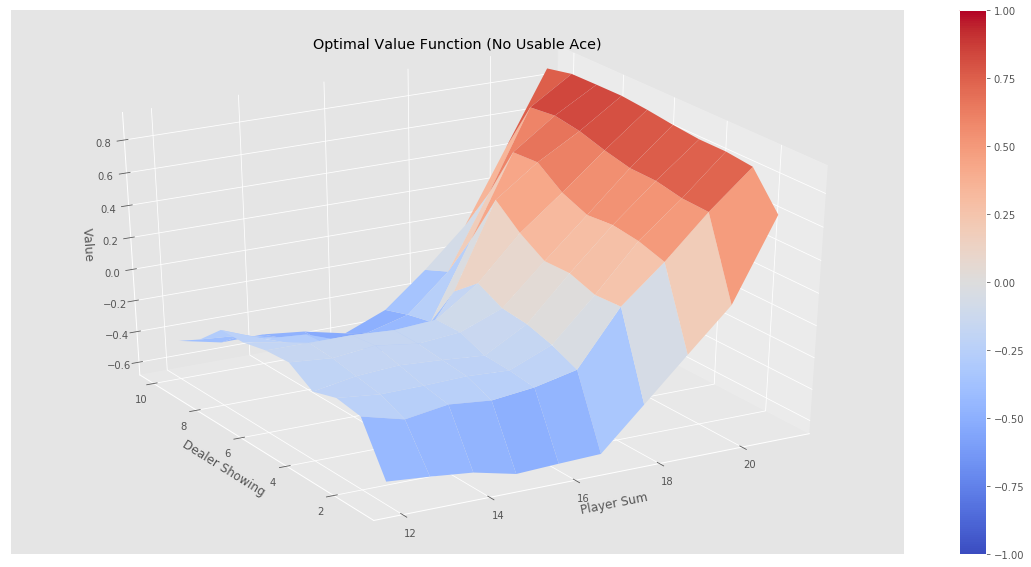

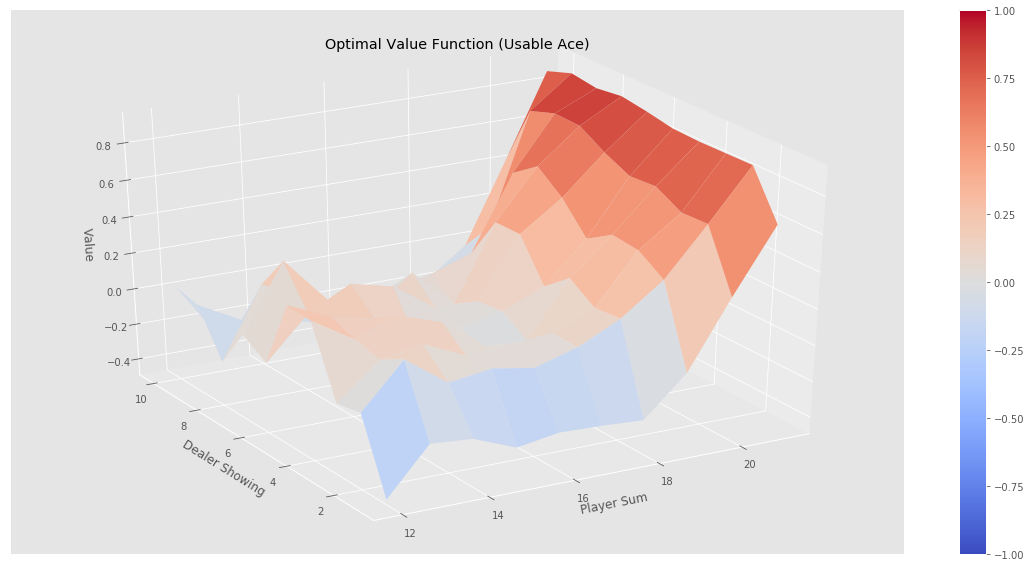

In [7]:
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")